In [57]:
# Locate project root dir, enable package imports from src/
import sys
from pathlib import Path

PROJ_ROOT = Path().resolve().parents[1]
sys.path.append(str(PROJ_ROOT / "src"))
print(PROJ_ROOT)

/Users/alexandre/Documents/GitHub/car_price_predictor


In [58]:
import os

# Load standardized paths, ml utilities and custom transformer
from project_utils.paths import CLEANED_DATA_DIR, TEST_PREDICTIONS_DIR
import project_utils.ml_utils as ml_utils
import project_utils.custom_transformers as custom_transformers

import pandas as pd
import numpy as np

# Data splitting and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib  # Allows pipeline exportation

# ΦK correlation coefficient and supporting visualization libraries
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

# Feature select, hyperparameter tuning and model implementation
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV


In [59]:
df_train = pd.read_csv(
    os.path.join(CLEANED_DATA_DIR, "cleaned_train_data.csv"), index_col="carID"
)
X_test = pd.read_csv(
    os.path.join(CLEANED_DATA_DIR, "cleaned_test_data.csv"), index_col="carID"
)

# Holdout split and prepare data for the modelling pipeline

In [60]:
# Performing the holdout
X = df_train.drop(columns="price")
y = df_train["price"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [61]:
metric_features = X_train.select_dtypes(exclude="object")
# Identify outliers using the IQR method (mask is True for outlier values)
outlier_counts, outlier_mask = ml_utils.count_outliers(metric_features, iqr_range=3.5)
outlier_counts

year                149
mileage             182
tax               13520
mpg                 291
engineSize           81
paintQuality%         0
previousOwners        0
hasDamage             0
dtype: int64

In [62]:
# Impute missing values for observations identified as outliers
X_train.loc[:, metric_features.columns] = metric_features.mask(
    outlier_mask, other=np.nan
)

# Pipeline implementation

In [63]:
# -- Compute and compare the global variance of each numerical feature with the variance conditioned on 'Brand' and on 'Brand'-'model' groups --#
print("Global variance vs. Brand-grouped variance:")
display(ml_utils.conditional_variance_comparison(X_train, ["Brand"]))

print("Global variance vs. Brand-Model grouped variance:")
display(ml_utils.conditional_variance_comparison(X_train, ["Brand", "model"]))

Global variance vs. Brand-grouped variance:


,global_variance,grouped_variance
year,4.134589e+00,4.041169e+00
mileage,4.238851e+08,4.163995e+08
tax,1.854301e+02,1.727557e+02
mpg,1.425395e+02,1.368348e+02
engineSize,2.922643e-01,2.010564e-01
paintQuality%,4.264744e+02,4.277570e+02
previousOwners,2.087652e+00,2.087396e+00
hasDamage,0.000000e+00,0.000000e+00


Global variance vs. Brand-Model grouped variance:


,global_variance,grouped_variance
year,4.134589e+00,3.705320e+00
mileage,4.238851e+08,3.648732e+08
tax,1.854301e+02,1.901643e+02
mpg,1.425395e+02,7.402537e+01
engineSize,2.922643e-01,9.408364e-02
paintQuality%,4.264744e+02,4.271502e+02
previousOwners,2.087652e+00,2.114658e+00
hasDamage,0.000000e+00,0.000000e+00


The preprocessing pipeline is designed to impute missing values (including outliers), encode categorical variables, and apply feature scaling. It comprises the following steps:

1. Grouped-Based imputation (Custom Transformer):

    To address missing values, a custom group-based imputation transformer was implemented. Its use is justified by the observed behaviour of the numerical features under different conditioning structures. Specifically, conditioning on the joint 'Brand–Model' grouping produces a substantial reduction in feature variance compared with both the global variance and the variance conditioned only on 'Brand' (e.g., for the feature 'mpg'). This decrease indicates that the distribution of these numerical variables is more homogeneous within 'Brand–Model' groups, thereby supporting the use of group-level statistics for more accurate and context-specific imputation

2. Encoding of Categorical Features:

    Target encoding was selected as the categorical encoding strategy. This choice was primarily motivated by the high number of unique category values observed in the model feature, which contains approximately 180 distinct entries—representing a moderately high cardinality. Applying one-hot encoding in this context would lead to a substantial increase in dimensionality, which can hinder the performance and generalisation ability of regression models [4][5]. Target encoding provides a more compact and statistically efficient alternative for handling such categorical variables.

3. Feature Scaling:

    Since target encoding produces continuous numeric values, these must be scaled jointly with origianl numerical variables to ensure comparibility. For feature scaling, we've decided to apply a data normalization scaling technique. This scaling technique was prefered for the following reasons:

    + The dataset contains skewed features such as 'mileage' and 'tax', making standardization scaling inappropriate for this context.

    + Although a small number of outliers were intentionally retained, the distributions are not sufficiently heavy-tailed to justify median-interquartile range scaling.

    + Min–Max scaling preserves the original shape and relative structure of feature distributions while mapping all variables to a common range, a useful property when combining heterogeneous numeric and encoded features [6].

In [64]:
# numeric_cols = X_train.select_dtypes(exclude="object").columns.to_list()
numeric_cols = X_train.select_dtypes(exclude="object").columns.to_list()
categorical_cols = X_train.select_dtypes(include="object").columns.to_list()

In [65]:
pre_pipeline = Pipeline(
    steps=[
        (
            "group_imputer",
            custom_transformers.BrandModelGroupImputer(
                brand_col="Brand", model_col="model"
            ),
        ),
        (
            "column_transformer",
            ColumnTransformer(
                transformers=[
                    # Pass numeric features through
                    ("num", "passthrough", numeric_cols),
                    # Target-encode categorical features
                    (
                        "cat",
                        TargetEncoder(
                            categories="auto",
                            target_type="continuous",
                            smooth="auto",
                        ),
                        categorical_cols,
                    ),
                ],
            ),
        ),
        # Scale all features (numeric + target-encoded)
        ("scaler", MinMaxScaler()),
    ]
)

In [66]:
# Exports the preprocessing pipeline
joblib.dump(
    pre_pipeline,
    os.path.join(PROJ_ROOT, "src", "project_utils", "pre_pipeline.joblib"),
)
# Display the preprocessing pipeline diagram
pre_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('group_imputer', ...), ('column_transformer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,brand_col,'Brand'
,model_col,'model'
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, 

In [67]:
# Run the preprocessing pipeline on all dataset splits and export the resulting CSV files
X_train_preprocessed, X_val_preprocessed, X_test_preprocessed = (
    ml_utils.preprocess_export_splits(
        pre_pipeline, X_train, X_val, X_test, y_train=y_train, csv=True
    )
)
X_train_preprocessed.describe()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand,model,transmission,fuelType
count,60778.000000,60778.000000,60778.000000,60778.000000,60778.000000,60778.000000,60778.000000,60778.0,60778.000000,60778.000000,60778.000000,60778.000000
mean,0.793900,0.189999,0.361554,0.461311,0.180082,0.643018,0.322012,0.0,0.459470,0.204537,0.383685,0.451792
std,0.140969,0.167354,0.111123,0.096254,0.145095,0.204580,0.222687,0.0,0.365370,0.094673,0.442342,0.470871
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001320,-0.002364,0.001198,0.028293
25%,0.714286,0.068207,0.350000,0.401372,0.054054,0.476177,0.159786,0.0,0.156456,0.132070,0.001198,0.028293
50%,0.785714,0.145212,0.350000,0.465695,0.162162,0.640513,0.319572,0.0,0.454836,0.191374,0.001198,0.028293
75%,0.928571,0.261354,0.350000,0.517153,0.270270,0.815121,0.479358,0.0,0.878000,0.262538,0.761184,0.976128
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.995326,0.883888,0.994044,0.979426


# Feature selection and model implementation

## Filter methods

To characterize correlations across all features of the processed 'X_train', the $\phi_k$ correlation coefficient was employed. $\phi_k$ is a recently proposed association measure that provides a unified framework for quantifying relationships between numerical, ordinal, and categorical variables, while retaining a Pearson-like interpretation for interval-scaled data [3].

interval columns not set, guessing: ['price', 'year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage', 'Brand', 'model', 'transmission', 'fuelType']


/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable hasDamage for analysis 1. Dropping this column
  warnings.warn(
python(43361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43368) MallocStackLogging: can't turn off malloc stack logging because it was not 

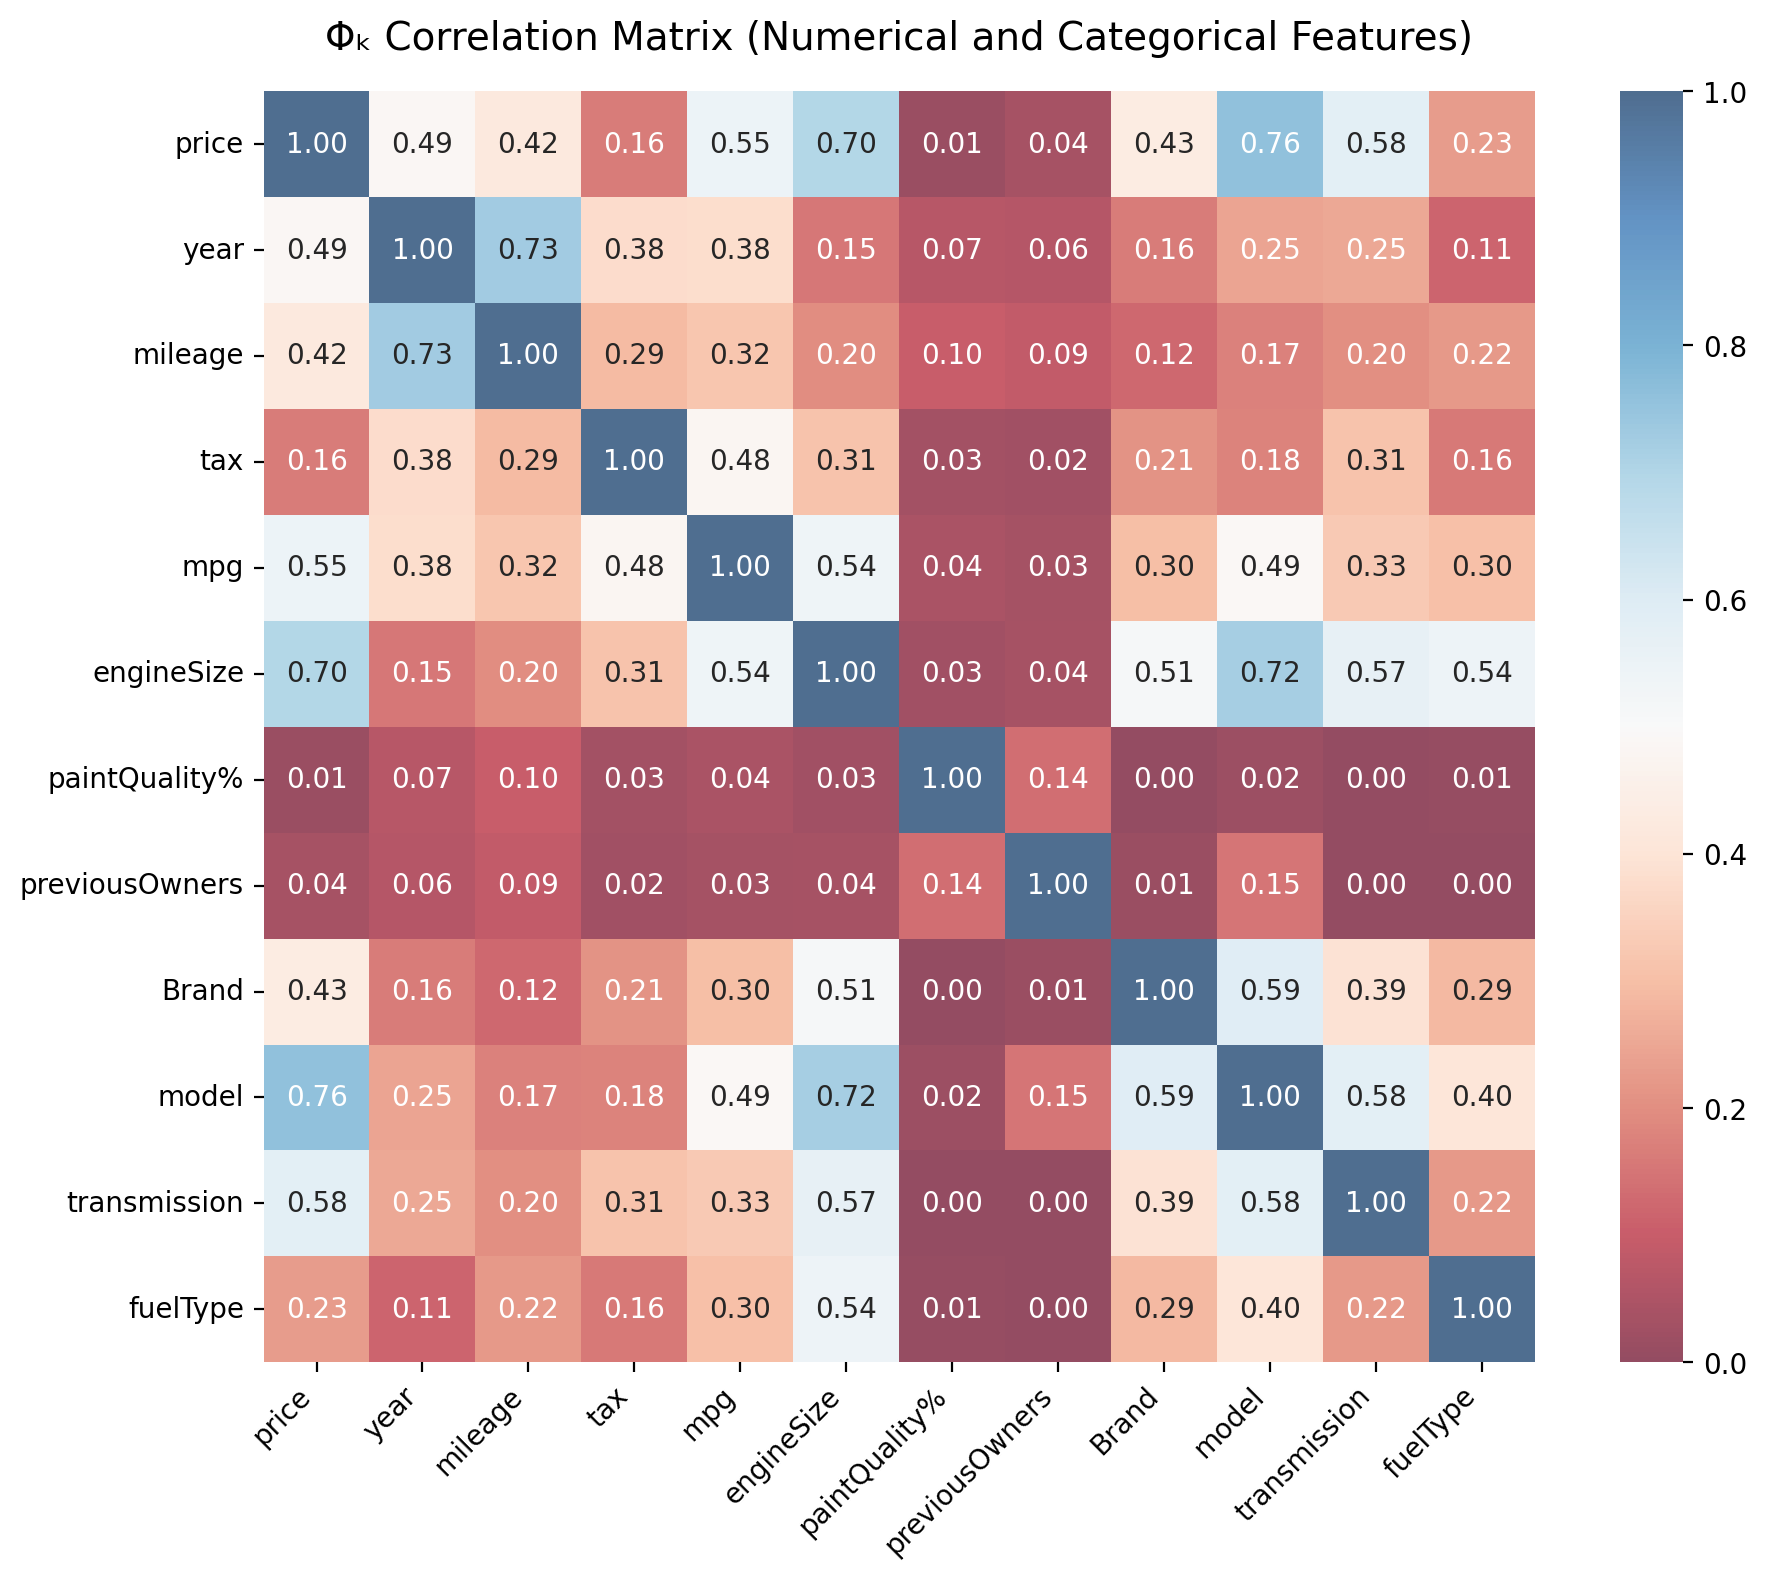

In [68]:
# Φ_k correlation matrix (works with numeric + categorical)
phi_k_corr = pd.concat([y_train, X_train_preprocessed], axis=1).phik_matrix()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    phi_k_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu",
    center=0.5,  # In acordance with the feature scaling
    square=True,
    alpha=0.7,
)

plt.title(
    "Φₖ Correlation Matrix (Numerical and Categorical Features)", fontsize=14, pad=15
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [69]:
X_train_preprocessed.var()

year              0.019872
mileage           0.028007
tax               0.012348
mpg               0.009265
engineSize        0.021052
paintQuality%     0.041853
previousOwners    0.049589
hasDamage         0.000000
Brand             0.133495
model             0.008963
transmission      0.195666
fuelType          0.221720
dtype: float64

When inspecting the $\phi_k$ correlation heatmap, we observe that the features 'paintQuality%' and 'previousOwners' exhibit virtually no correlation with any other variable in the dataset (including the target). Furthermore, the feature 'hasDamage' is absent from the heatmap because the $\phi_k$ statistic cannot be computed for constant variables, that is, variables with no variability in their values. Additionally, this interpretation is supported by the variance analysis, which confirms that 'hasDamage' has a variance of zero. Consequently, these features were removed, as they do not contribute meaningful infomation to the modelling process

In [70]:
X_train_preprocessed.drop(
    columns=["paintQuality%", "previousOwners", "hasDamage"], inplace=True
)
X_val_preprocessed.drop(
    columns=["paintQuality%", "previousOwners", "hasDamage"], inplace=True
)
X_test_preprocessed.drop(
    columns=["paintQuality%", "previousOwners", "hasDamage"], inplace=True
)

# Model implementation

In [71]:
print("Target skewness:", round(y_train.skew(), 3))
print("-"*60)
print(
    "Target skewness after logarithmic transformation:",
    round(np.log(y_train).skew(), 3),
)

Target skewness: 2.238
------------------------------------------------------------
Target skewness after logarithmic transformation: -0.152


Referring back to the data_cleaning notebook, an initial comparison between the mean and median of the target variable (price) indicated the presence of skewness. A formal assessment confirmed this, yielding a skewness coefficient of approximately 2.238. This value reflects a strongly asymmetric, right-tailed distribution—a pattern frequently observed in real-world price data. Such skewness has important implications for regression modelling, as it is commonly associated with heteroscedasticity, instability in parameter estimation, and degraded predictive performance at higher target values [1][2].

Applying a logarithmic transformation to the target produced a substantially more symmetrical distribution, reducing the skewness to –0.152. This improvement supports both the statistical motivation and the empirical value of the transformation. When incorporated into the modelling pipeline, the log-transformed target further improved predictive performance, reinforcing its suitability. The transformation was implemented using scikit-learn’s TransformedTargetRegressor [8], which applies a nonlinear transformation (e.g., natural log) during model fitting and automatically maps predictions back to the original target scale.

Given the relatively small number of features and the moderate pairwise correlations observed (approximately 0.1–0.7), none of the predictors appeared to be strongly redundant. As a result, wrapper-based feature selection methods such as Recursive Feature Elimination (RFE) were unlikely to provide meaningful advantages in this setting. Instead, an embedded feature-selection approach was adopted using Elastic Net regression. Elastic Net combines the strengths of both L1 (Lasso) and L2 (Ridge) regularisation, allowing for simultaneous coefficient shrinkage and feature selection. This makes it a more robust and reliable alternative to pure Lasso, offering a well-behaved selection process and flexible hyperparameter tuning through the joint control of L1 and L2 penalties [6].

In [72]:
# --- Base model --- #
log_lin_regressor = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1
)

model = Pipeline(
    [
        (
            "feature_selection",
            SelectFromModel(
                ElasticNet(alpha=0.1, l1_ratio=0.2, random_state=0, max_iter=100_000)
            ),
        ),
        ("regressor", log_lin_regressor),
    ]
)

model.fit(X_train_preprocessed, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_selection', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"estimator estimator: objectThe base estimator from which the transformer is built.This can be both a fitted (if ``prefit`` is set to True)or a non-fitted estimator. The estimator should have a``feature_importances_`` or ``coef_`` attribute after fitting.Otherwise, the ``importance_getter`` parameter should be used.",ElasticNet(al...andom_state=0)
,"threshold threshold: str or float, default=NoneThe threshold value to use for feature selection. Features whoseabsolute importance value is greater or equal are kept while the othersare discarded. If ""median"" (resp. ""mean""), then the ``threshold`` valueis the median (resp. the mean) of the feature importances. A scalingfactor (e.g., ""1.25*mean"") may also be used. If None and if theestimator has a parameter penalty set to l1, either explicitlyor implicitly (e.g, Lasso), the threshold used is 1e-5.Otherwise, ""mean"" is used by default.",None
,"prefit prefit: bool, default=FalseWhether a prefit model is expected to be passed into the constructordirectly or not.If `True`, `estimator` must be a fitted estimator.If `False`, `estimator` is fitted and updated by calling`fit` and `partial_fit`, respectively.",False
,"norm_order norm_order: non-zero int, inf, -inf, default=1Order of the norm used to filter the vectors of coefficients below``threshold`` in the case where the ``coef_`` attribute of theestimator is of dimension 2.",1
,"max_features max_features: int, callable, default=NoneThe maximum number of features to select.- If an integer, then it specifies the maximum number of features to allow.- If a callable, then it specifies how to calculate the maximum number of features allowed. The callable will receive `X` as input: `max_features(X)`.- If `None`, then all features are kept.To only select based on ``max_features``, set ``threshold=-np.inf``... versionadded:: 0.20.. versionchanged:: 1.1 `max_features` accepts a callable.",None
,"importance_getter importance_getter: str or callable, default='auto'If 'auto', uses the feature importance either through a ``coef_``attribute or ``feature_importances_`` attribute of estimator.Also accepts a string that specifies an attribute na

In [73]:
selector = model.named_steps["feature_selection"]

# Boolean mask of selected features
mask_selected = selector.get_support()
# Fitted ElasticNet model
enet_params = selector.estimator_
# Fitted coefficients
coefs = enet_params.coef_

coef_table = pd.DataFrame(
    {"coef": coefs, "selected": mask_selected}, index=X_train_preprocessed.columns
)

coef_table

,coef,selected
year,5041.923231,True
mileage,-5100.724129,True
tax,-69.868079,False
mpg,-3074.073048,False
engineSize,4859.433374,True
Brand,5173.819154,True
model,3941.975602,True
transmission,5399.853042,True
fuelType,1015.625949,False


Elastic Net identified ‘tax’, 'mpg' and ‘fuelType’ as the least informative predictors (despite having small non-zero coefficients) and removed them, retaining only the features with the strongest and most meaningful contributions to the price prediction.

In [74]:
# Compute evaluation metrics for the training and validation sets
# Training set
pred_train = model.predict(X_train_preprocessed)
print("Training set metrics:")
metrics_train = ml_utils.linear_evaluation_metrics(y_train, pred_train, verbose=True)
# Validation set
pred_val = model.predict(X_val_preprocessed)
print("Validation set metrics:")
metrics_val = ml_utils.linear_evaluation_metrics(y_val, pred_val, verbose=True)

Training set metrics:
R²: 0.806, MAE: 2465.00, MAPE: 15.87%, RMSE: 4275.35
-------------------------------------------------------
Validation set metrics:
R²: 0.799, MAE: 2476.68, MAPE: 14.75%, RMSE: 4414.64
-------------------------------------------------------


/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: overflow encountered in ma

The model demonstrates solid and reliable performance across both the training and validation sets. On the training set, it achieves an $R^2$ of 0.806, indicating that the model explains approximately 80% of the variance in car prices. The validation set shows a very similar $R^2$ of 0.803, accompanied by comparable mean absolute error (MAE) and mean absolute percentage error (MAPE) values. This close correspondence between training and validation metrics suggests that the model generalises well to unseen data, with no evidence of overfitting. Additionally, a MAPE between 14% and 16% implies that predictions deviate from actual prices by roughly 15% on average; a reasonable deviation considering that car prices in the dataset range from approximately 450 to 16 000.

Nonetheless, while this linear model performs well, it may not fully capture complex non-linear relationships present in the dataset. Even when properly tuned, linear regression remains limited to modelling linear patterns. Consequently, non-linear models or ensemble methods may yield superior predictive performance in future iterations of the project.

In [76]:
# -- Export X_test predictions --#
pred_test = model.predict(X_test_preprocessed)

# Convert to Series
test_predictions_series = pd.Series(
    data=pred_test, name="price", index=X_test_preprocessed.index
)

# Export CSV file
test_predictions_series.to_csv(
    os.path.join(TEST_PREDICTIONS_DIR, "lr_test_predictions.csv")
)

/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [75]:
# # Export the HGBR pipeline with the best parameters found via RandomizedSearchCV
# lr_full_pipeline = Pipeline([("pre_pipeline", pre_pipeline), ("model", model)])
# joblib.dump(lr_full_pipeline, os.path.join(PROJ_ROOT, "src", "models", "LR.joblib"))

['/Users/alexandre/Documents/GitHub/car_price_predictor/src/models/LR.joblib']

## References
[1]	J. W. Osborne, “Improving your data transformations: Applying the Box-Cox transformation”.

[2]	L. Nuyts and J. Davis, “The When and How of Target Variable Transformations,” Apr. 29, 2025, arXiv: arXiv:2504.20821. doi: 10.48550/arXiv.2504.20821.

[3]	M. Baak, R. Koopman, H. Snoek, and S. Klous, “A new correlation coefficient between categorical, ordinal and interval variables with Pearson characteristics,” Mar. 09, 2019, arXiv: arXiv:1811.11440. doi: 10.48550/arXiv.1811.11440.

[4]	D. Micci-Barreca, “A preprocessing scheme for high-cardinality categorical attributes in classification and prediction problems,” SIGKDD Explor. Newsl., vol. 3, no. 1, pp. 27–32, July 2001, doi: 10.1145/507533.507538.

[5] K. Johnson and M. Kuhn, Feature Engineering and Selection: A Practical Approach for Predictive Models. Boca Raton, FL, USA: CRC Press, 2019.

[6] Scikit-learn developers, “sklearn.preprocessing.MinMaxScaler,” scikit-learn: Machine Learning in Python, 2024. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

[7] A. C. Müller and S. Guido, Introduction to Machine Learning with Python: A Guide for Data Scientists. Sebastopol, CA: O’Reilly Media, 2016.

[8] Scikit-learn developers, “sklearn.compose.TransformedTargetRegressor,” scikit-learn: Machine Learning in Python, 2024 [Online] Available: https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html
